# Figure 6 script

This notebook requires additional steps to be reproduced:

1. Make sure you have installed all necessary packages, including vmap and others specified in the cell below.
2. Update the input file paths so they point to the actual files on your local machine. These files include the source Landsat 8 image (`LC08_L1TP_061018_20180304_20180319_01_T1_B8_s.TIF`, downloadable at https://doi.org/10.17605/OSF.IO/HE7YR) and the RGI glacier outline (`01_rgi60_Alaska.shp`, downloadable at https://doi.org/10.7265/4m1f-gd79).

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys,glob
from pygeotools.lib import geolib,iolib,warplib,malib
from imview import pltlib
import rasterio
import geopandas as gpd

In [2]:
%matplotlib inline

In [3]:
%cd /nobackup/sbhusha1/feature_tracking_wg

/nobackupp11/sbhusha1/feature_tracking_wg


In [6]:

img_fn = 'Cropped/LC08_L1TP_061018_20180304_20180319_01_T1_B8_s.TIF'

In [7]:

def create_synthetic_offset(imgfile, mode='subpixel', block_size=500):
    """
    imgfile: str, geotiff file path
    mode: 'subpixel' or 'multipixel'
    block_size: int, increment block size
    ----
    returns:
    shift_arx: np.ndarray, offset field (x), in pixels
    shift_ary: np.ndarray, offset field (y), in pixels
    ----
    """  
    with rasterio.open(imgfile) as src:
        data_shape = (src.height, src.width)
    idxy, idxx = np.indices(data_shape)   
    # for Numpy array, first is row element (-> geotiff's y direction, height) 
    # and second is column element (-> geotiff's x direction, width)
    
    if mode == 'subpixel':
        shift_arx = idxx // block_size
        shift_arx = 0.1 * shift_arx + 0.1
        shift_ary = idxy // block_size
        shift_ary = -0.1 * shift_ary - 0.1
    elif mode == 'multipixel':
        shift_arx = 1 + idxx // block_size
        shift_ary = -1 - idxy // block_size
    else:
        raise ValueError('Mode is not defined.')
        
    return shift_arx, shift_ary

def apply_synthetic_offset(imgfile, shift_arx, shift_ary, spline_order=1):
    """
    imgfile: str, geotiff file path
    shift_arx: np.ndarray, offset field (x) from gftt.create_synthetic_offset
    shift_ary: np.ndarray, offset field (y) from gftt.create_synthetic_offset
    ----
    returns:
    ----
    """ 
    import rasterio
    from scipy.ndimage import map_coordinates
    with rasterio.open(imgfile) as src:
        data_shape = (src.height, src.width)
        data = src.read(1)
    idxy, idxx = np.indices(data_shape)
    shifted_y = idxy + shift_ary
    shifted_x = idxx + shift_arx
    shifted_yx = np.vstack((shifted_y.flatten(), shifted_x.flatten()))
    
    shifted_val = map_coordinates(data, shifted_yx, order=spline_order, mode='nearest')
    shifted_val = np.reshape(shifted_val, data_shape)
    
    return shifted_val

In [9]:
data_shape = img.shape
shift_arx, shift_ary = create_synthetic_offset(img_fn)
shift_arx


array([[0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       ...,
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8]])

In [11]:

shifted_image = apply_synthetic_offset(img_fn, shift_arx, shift_ary)
outfn = os.path.splitext(img_fn)[0]+'_subpixel_shift.tif'
iolib.writeGTiff(shifted_image,outfn,src_ds=ds_list[2],ndv=0)

<Axes: >

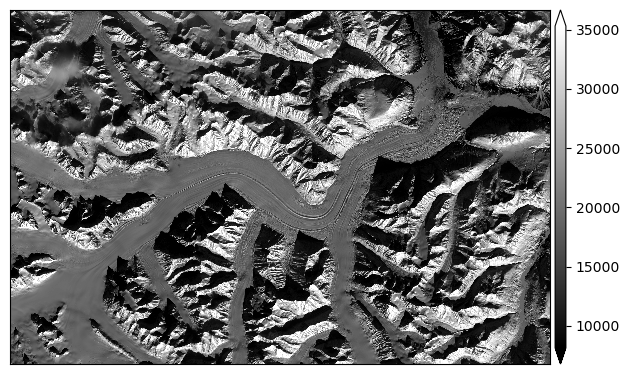

In [12]:
f,ax = plt.subplots()
pltlib.iv(iolib.fn_getma(outfn),ax=ax,cmap='gray')

In [17]:
!vmap.py $img_fn $outfn -dt none


2023-07-08 02:11:05.369578
2023-07-08 09:11:05.369647 UTC


Warping all inputs to the following:
Resolution: 15.0
Extent: [584872.5, 6717982.5, 641572.5, 6755182.5]
Projection: '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs'
Resampling alg: average

1 of 2: Cropped/LC08_L1TP_061018_20180304_20180319_01_T1_B8_s.TIF
2 of 2: Cropped/LC08_L1TP_061018_20180304_20180319_01_T1_B8_s_subpixel_shift.tif
/nobackupp16/swbuild3/sbhusha1/StereoPipeline-3.2.1-alpha-2023-04-19-x86_64-Linux/bin/stereo_pprc -t pinhole --threads 56 --alignment-method None --corr-kernel 35 35 --corr-max-levels 5 --corr-timeout 1200 --subpixel-mode 1 --subpixel-kernel 35 35 --stereo-algorithm asp_bm --erode-max-size 1024 LC08_L1TP_061018_20180304_20180319_01_T1_B8_s__LC08_L1TP_061018_20180304_20180319_01_T1_B8_s_subpixel_shift_vmap_minm_35px_spm1/LC08_L1TP_061018_20180304_20180319_01_T1_B8_s_warp.tif LC08_L1TP_061018_20180304_20180319_01_T1_B8_s__LC08_L1TP_061018_20180304_20180319_01_T1_B8_s_subpixel_shift_vmap_minm_35

In [18]:
out_disp_fn = 'LC08_L1TP_061018_20180304_20180319_01_T1_B8_s__LC08_L1TP_061018_20180304_20180319_01_T1_B8_s_subpixel_shift_vmap_minm_35px_spm1/vmap-F.tif'
out_dx,out_dy = [iolib.fn_getma(out_disp_fn,b) for b in [1,2]]

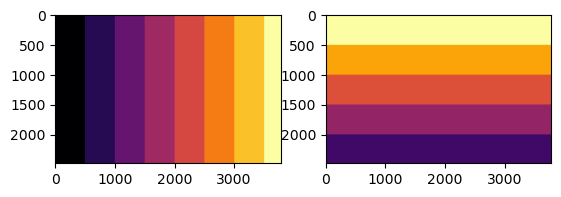

In [19]:
f,ax = plt.subplots(1,2)
clim_x = (0.1,0.8)
clim_y = (-0.6,-0.1)
cb1 = ax[0].imshow(shift_arx,cmap='inferno',clim=clim_x)
cb2 = ax[1].imshow(shift_ary,cmap='inferno',clim=clim_y)

In [20]:
ds = iolib.fn_getds(out_disp_fn)
extent = geolib.ds_extent(ds)
fig_extent = [extent[0],extent[2],extent[1],extent[3]]

In [25]:
glac_shp = gpd.read_file('/nobackup/sbhusha1/reference_data/rgi60/regions/01_rgi60_Alaska.shp')

In [28]:
kaskwulsh_mask = glac_shp['RGIId'] == 'RGI60-01.16201'
kaskwulsh_shp = (glac_shp[kaskwulsh_mask]).to_crs("EPSG:32607")

<Axes: >

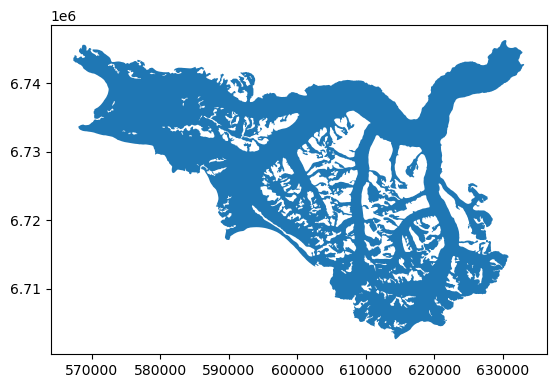

In [29]:
kaskwulsh_shp.plot()

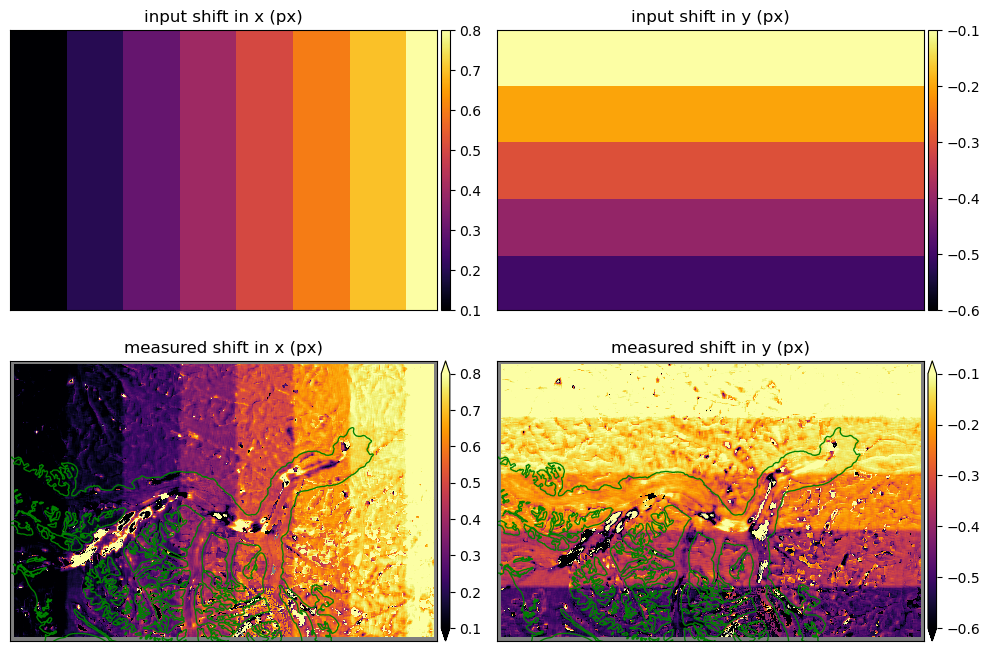

In [35]:
f,axa = plt.subplots(2,2,figsize=(10,8),sharex=True,sharey=True)
ax = axa.ravel()
clim_x = (0.1,0.8)
clim_y = (-0.6,-0.1)
pltlib.iv(shift_arx,ax=ax[0],cmap='inferno',clim=clim_x,title='input shift in x (px)',extent=fig_extent)
pltlib.iv(shift_ary,ax=ax[1],cmap='inferno',clim=clim_y,title='input shift in y (px)',extent=fig_extent)
kaskwulsh_shp.plot(ax=ax[2],facecolor="None",edgecolor='green',linewidth=0.95)
kaskwulsh_shp.plot(ax=ax[3],facecolor="None",edgecolor='green',linewidth=0.95)
pltlib.iv(-1*out_dx,ax=ax[2],cmap='inferno',clim=clim_x,cbar=False,title='measured shift in x (px)',extent=fig_extent)
pltlib.add_cbar(ax[2],mappable=cb1)
pltlib.iv(-1*out_dy,ax=ax[3],cmap='inferno',clim=clim_y,cbar=False,title='measured shift in y (px)',extent=fig_extent)

pltlib.add_cbar(ax[3],cb2)
plt.tight_layout()
#f.savefig('figure6_manuscript.png',dpi=300,bbox_inches='tight', pad_inches=0.1)
f.savefig('/nobackup/sbhusha1/notebooks/velocity/figure6_manuscript_revised_kaskawulsh_only.png',dpi=300,bbox_inches='tight', pad_inches=0.1)
